In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyaccel import lattice as pyacc_lat
from pyaccel import optics as pyacc_opt
from pyaccel.optics import calc_touschek_energy_acceptance
from mathphys.functions import save_pickle, load_pickle
from apsuite.dynap import DynapXY, DynapEX, PhaseSpace
import pyaccel
import pymodels

from idanalysis import orbcorr as orbcorr

from idanalysis import optics as optics
from idanalysis import IDKickMap
import utils

In [2]:
def create_model_ids(gap, width, rescale_kicks, shift_kicks):
    """."""
    print('--- model with kickmap ---')
    ids = utils.create_ids(
        gap, width, rescale_kicks=rescale_kicks, shift_kicks=shift_kicks)
    model = pymodels.si.create_accelerator(ids=ids)
    model.cavity_on = False
    model.radiation_on = 0
    twiss, *_ = pyaccel.optics.calc_twiss(model, indices='closed')
    print('length : {:.4f} m'.format(model.length))
    print('tunex  : {:.6f}'.format(twiss.mux[-1]/2/np.pi))
    print('tuney  : {:.6f}'.format(twiss.muy[-1]/2/np.pi))
    straight_nr = int(ids[0].subsec[2:4])

    # get knobs and beta locations
    if straight_nr is not None:
        _, knobs, _ = optics.symm_get_knobs(model, straight_nr)
        locs_beta = optics.symm_get_locs_beta(knobs)
    else:
        knobs, locs_beta = None, None

    return model, knobs, locs_beta, straight_nr

In [11]:
def create_models(gap, width, rescale_kicks, shift_kicks):

    # create unperturbed model for reference
    model0 = pymodels.si.create_accelerator()
    model0.cavity_on = False
    model0.radiation_on = 0

    # create model with id
    model1, knobs, locs_beta, straight_nr = create_model_ids(gap, width, rescale_kicks=rescale_kicks, shift_kicks=shift_kicks)

    # return
    return model0, model1, knobs, locs_beta, straight_nr

In [31]:
def plot_beta_beating(
    twiss0, twiss1, twiss2, twiss3, width, gap, knobs, dk_tot):
    """."""
    config_label = 'width = {} mm, gap = {}'.format(width, gap)
    figpath = './results/model/width_{}/'.format(width)
    gap_str = '{:04.1f}'.format(gap).replace('.', 'p')

    stg = str()
    for i, fam in enumerate(knobs):
        stg += '{:<9s} dK: {:+9.6f} 1/m² \n'.format(fam, dk_tot[i])
    print(stg)

    # Compare optics between nominal value and uncorrect optics due ID
    results = calc_dtune_betabeat(twiss0, twiss1)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]
    print('Not symmetrized optics :')
    print(f'dtunex: {dtunex:+.2e}')
    print(f'dtuney: {dtuney:+.2e}')
    print(f'bbetax: {bbeatx_rms:04.3f} % rms, {bbeatx_absmax:04.3f} % absmax')
    print(f'bbetay: {bbeaty_rms:04.3f} % rms, {bbeaty_absmax:04.3f} % absmax')
    print()

    plt.figure(1)
    labelx = f'X ({bbeatx_rms:.3f} % rms)'
    labely = f'Y ({bbeaty_rms:.3f} % rms)'
    plt.plot(twiss0.spos, bbeatx, color='b', alpha=1.0, label=labelx)
    plt.plot(twiss0.spos, bbeaty, color='r', alpha=0.8, label=labely)
    plt.xlabel('spos [m]')
    plt.ylabel('Beta Beating [%]')
    plt.title('Beta Beating from ID - ' + config_label)
    plt.suptitle('Not symmetrized optics')
    plt.legend()
    plt.grid()
    plt.savefig(figpath + 'uncorrected-optics-gap-{}.'.format(gap_str), dpi=300)
    plt.close()

    # Compare optics between nominal value and symmetrized optics
    results = calc_dtune_betabeat(twiss0, twiss2)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]
    print('symmetrized optics but uncorrect tunes:')
    print(f'dtunex: {dtunex:+.0e}')
    print(f'dtuney: {dtuney:+.0e}')
    print(f'bbetax: {bbeatx_rms:04.3f} % rms, {bbeatx_absmax:04.3f} % absmax')
    print(f'bbetay: {bbeaty_rms:04.3f} % rms, {bbeaty_absmax:04.3f} % absmax')
    print()

    plt.figure(2)
    labelx = f'X ({bbeatx_rms:.3f} % rms)'
    labely = f'Y ({bbeaty_rms:.3f} % rms)'
    plt.plot(twiss0.spos, bbeatx, color='b', alpha=1.0, label=labelx)
    plt.plot(twiss0.spos, bbeaty, color='r', alpha=0.8, label=labely)
    plt.xlabel('spos [m]')
    plt.ylabel('Beta Beating [%]')
    plt.title('Beta Beating from ID - ' + config_label)
    plt.suptitle('Symmetrized optics and uncorrect tunes')
    plt.legend()
    plt.grid()
    plt.savefig(figpath + 'corrected-optics-gap{}.'.format(gap_str), dpi=300)
    plt.close()

    # Compare optics between nominal value and all corrected
    results = calc_dtune_betabeat(twiss0, twiss3)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]
    print('symmetrized optics and correct tunes:')
    print(f'dtunex: {dtunex:+.0e}')
    print(f'dtuney: {dtuney:+.0e}')
    print(f'bbetax: {bbeatx_rms:04.3f} % rms, {bbeatx_absmax:04.3f} % absmax')
    print(f'bbetay: {bbeaty_rms:04.3f} % rms, {bbeaty_absmax:04.3f} % absmax')

    plt.figure(3)
    labelx = f'X ({bbeatx_rms:.3f} % rms)'
    labely = f'Y ({bbeaty_rms:.3f} % rms)'
    plt.plot(twiss0.spos, bbeatx, color='b', alpha=1.0, label=labelx)
    plt.plot(twiss0.spos, bbeaty, color='r', alpha=0.8, label=labely)
    plt.xlabel('spos [m]')
    plt.ylabel('Beta Beating [%]')
    plt.title('Beta Beating from ID - ' + config_label + '\n' + stg)
    plt.suptitle('Symmetrized optics and correct tunes')
    plt.tight_layout()
    plt.legend()
    plt.grid()
    plt.savefig(figpath + 'corrected-optics-tunes-gap{}.'.format(gap_str), dpi=300)
    plt.close()

In [5]:
def calc_dtune_betabeat(twiss0, twiss1):
  """."""
  dtunex = (twiss1.mux[-1] - twiss0.mux[-1]) / 2 / np.pi
  dtuney = (twiss1.muy[-1] - twiss0.muy[-1]) / 2 / np.pi
  bbeatx = 100 * (twiss1.betax - twiss0.betax) / twiss0.betax
  bbeaty = 100 * (twiss1.betay - twiss0.betay) / twiss0.betay
  bbeatx_rms = np.std(bbeatx)
  bbeaty_rms = np.std(bbeaty)
  bbeatx_absmax = np.max(np.abs(bbeatx))
  bbeaty_absmax = np.max(np.abs(bbeaty))
  return (
    dtunex, dtuney, bbeatx, bbeaty,
    bbeatx_rms, bbeaty_rms, bbeatx_absmax, bbeaty_absmax)

In [6]:
def analysis_uncorrected_perturbation(
        width, model, twiss0=None, plot_flag=True):
    """."""
    config_label = 'width = {} mm'.format(width)
    twiss, *_ = pyacc_opt.calc_twiss(model, indices='closed')

    results = calc_dtune_betabeat(twiss0, twiss)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]

    if plot_flag:

        print(f'dtunex: {dtunex:+.6f}')
        print(f'dtunex: {dtuney:+.6f}')
        txt = f'bbetax: {bbeatx_rms:04.1f} % rms, '
        txt += f'{bbeatx_absmax:04.1f} % absmax'
        print(txt)
        txt = f'bbetay: {bbeaty_rms:04.1f} % rms, '
        txt += f'{bbeaty_absmax:04.1f} % absmax'
        print(txt)

        labelx = f'X ({bbeatx_rms:.1f} % rms)'
        labely = f'Y ({bbeaty_rms:.1f} % rms)'
        plt.plot(twiss.spos, bbeatx, color='b', alpha=1, label=labelx)
        plt.plot(twiss.spos, bbeaty, color='r', alpha=0.8, label=labely)
        plt.xlabel('spos [m]')
        plt.ylabel('Beta Beat [%]')
        plt.title('Beta Beating from ID - ' + config_label)
        plt.legend()
        plt.grid()
        plt.show()

    return twiss

In [7]:
def calc_idkmap_kicks(plane_idx=0, plot_flag=False, idkmap=None):
    """."""
    brho = 10.007
    kickx_end = idkmap.kickx_upstream + idkmap.kickx_downstream
    kicky_end = idkmap.kicky_upstream + idkmap.kicky_downstream
    rx0 = idkmap.posx
    ry0 = idkmap.posy
    rxf = idkmap.fposx[plane_idx, :]
    ryf = idkmap.fposy[plane_idx, :]
    pxf = (idkmap.kickx[plane_idx, :] + kickx_end) / brho**2
    pyf = (idkmap.kicky[plane_idx, :] + kicky_end) / brho**2
    if plot_flag:
        plt.plot(1e3*rx0, 1e6*pxf, '.-', label='Kick X', color='C1')
        plt.plot(1e3*rx0, 1e6*pyf, '.-', label='Kick Y', color='b')
        plt.xlabel('init rx [mm]')
        plt.ylabel('final px [urad]')
        plt.title('Kicks')
        plt.legend()
        plt.grid()
        plt.show()

    return rx0, ry0, pxf, pyf, rxf, ryf

In [8]:
def calc_shift_kicks(gap, width):
      RESCALE_KICKS = 15.3846
      fname = utils.get_kmap_filename(gap, width)
      id_kickmap = IDKickMap(fname)

      plane_idx = list(id_kickmap.posy).index(0)

      rx0, ry0, pxf, pyf, rxf, ryf = calc_idkmap_kicks(
        idkmap=id_kickmap, plane_idx=plane_idx, plot_flag=False)

      posx_zero_idx = list(id_kickmap.posx).index(0)
      pxf_shift = pxf[posx_zero_idx]
      pyf_shift = pyf[posx_zero_idx]
      pxf -= pxf_shift
      pyf -= pyf_shift
      pxf *= RESCALE_KICKS
      pyf *= RESCALE_KICKS

      shift_kicks = [-pxf_shift * RESCALE_KICKS, -pyf_shift * RESCALE_KICKS]
      return shift_kicks

In [28]:
def symmetrize(gap, width, plot_flag=True):
    """."""
    shift_kicks = calc_shift_kicks(gap, width)
    model0, model1, knobs, locs_beta, straight_nr = create_models(gap, width, rescale_kicks=15.3846, shift_kicks=[0,0])
    twiss0, *_ = pyacc_opt.calc_twiss(model0, indices='closed')
    print('local quadrupole fams: ', knobs)
    print('element indices for straight section begin and end: ', locs_beta)

    # calculate nominal twiss
    goal_tunes = np.array(
        [twiss0.mux[-1] / 2 / np.pi, twiss0.muy[-1] / 2 / np.pi])
    goal_beta = np.array(
        [twiss0.betax[locs_beta], twiss0.betay[locs_beta]])
    goal_alpha = np.array(
        [twiss0.alphax[locs_beta], twiss0.alphay[locs_beta]])
    print(goal_beta)


    orb_results = orbcorr.correct_orbit_fb(
        model0, model1, 'IVU18', corr_system='SOFB')


    # calculate beta beating and tune delta tunes
    twiss1 = analysis_uncorrected_perturbation(
        width, model1, twiss0=twiss0, plot_flag=False)

    # symmetrize optics (local quad fam knobs)
    dk_tot = np.zeros(len(knobs))
    for i in range(7):
        dk = optics.correct_symmetry_withbeta(
            model1, straight_nr, goal_beta, goal_alpha)
        print('iteration #{}, dK: {}'.format(i+1, dk))
        dk_tot += dk
    for i, fam in enumerate(knobs):
        print('{:<9s} dK: {:+9.6f} 1/m²'.format(fam, dk_tot[i]))
    twiss2, *_ = pyacc_opt.calc_twiss(model1, indices='closed')
    print()

    # correct tunes
    tunes = twiss1.mux[-1]/np.pi/2, twiss1.muy[-1]/np.pi/2
    print('init    tunes: {:.9f} {:.9f}'.format(tunes[0], tunes[1]))
    for i in range(2):
        optics.correct_tunes_twoknobs(model1, goal_tunes)
        twiss, *_ = pyacc_opt.calc_twiss(model1)
        tunes = twiss.mux[-1]/np.pi/2, twiss.muy[-1]/np.pi/2
        print('iter #{} tunes: {:.9f} {:.9f}'.format(i+1, tunes[0], tunes[1]))
    print('goal    tunes: {:.9f} {:.9f}'.format(goal_tunes[0], goal_tunes[1]))
    twiss3, *_ = pyacc_opt.calc_twiss(model1, indices='closed')
    print()

    plot_beta_beating(
        twiss0, twiss1, twiss2, twiss3, width, gap, knobs, dk_tot)

    return model1

In [32]:
gap = 20
width = 43
gaps = [4.2, 20]
widths = [68, 63, 58, 53, 48, 43]
for width in widths:
    for gap in gaps:
        model1 = symmetrize(gap, width, plot_flag=False)
        # analysis_dynapt_map(model1, gap, width)

--- model with kickmap ---
length : 518.3899 m
tunex  : 49.095952
tuney  : 14.153692
local quadrupole fams:  {'QFB_ID': [2252, 2284], 'QDB1_ID': [2246, 2290], 'QDB2_ID': [2258, 2278]}
element indices for straight section begin and end:  [2246, 2291]
[[ 4.10424186  4.10329781]
 [22.3369932  22.3370103 ]]
iteration #1, dK: [ 0.00069614 -0.00339217 -0.00056888]
iteration #2, dK: [ 1.69029456e-05 -9.45547552e-05 -1.62948346e-05]
iteration #3, dK: [ 1.07975134e-08 -6.07270136e-08 -1.04754922e-08]
iteration #4, dK: [-1.55229033e-12  8.55423802e-12  1.47000332e-12]
iteration #5, dK: [ 4.60565085e-14 -8.82944332e-14 -9.78777763e-15]
iteration #6, dK: [ 4.92954517e-14 -4.20013654e-14  2.54435886e-16]
iteration #7, dK: [ 2.01587770e-14 -2.63949394e-13 -5.03319846e-14]
QFB_ID    dK: +0.000713 1/m²
QDB1_ID   dK: -0.003487 1/m²
QDB2_ID   dK: -0.000585 1/m²

init    tunes: 49.096001669 14.153537346
iter #1 tunes: 49.095963254 14.151787692
iter #2 tunes: 49.095963254 14.151787692
goal    tunes: 49.09

In [23]:
def analysis_dynapt_map(model1, gap, width):

    gap_str = '{:04.1f}'.format(gap).replace('.', 'p')
    model1.radiation_on = 0
    model1.cavity_on = False
    model1.vchamber_on = True

    dynapxy = DynapXY(model1)
    dynapxy.params.x_nrpts = 40
    dynapxy.params.y_nrpts = 20
    dynapxy.params.nrturns = 1*1024
    print(dynapxy)
    dynapxy.do_tracking()
    dynapxy.process_data()
    fig2, *ax = dynapxy.make_figure_diffusion(orders=(1, 2, 3, 4))
    fig2.show()

    fig_path = './results/model/width_{}/dynapt-kickmap-gap{}-width{}-symmetrized.png'.format(width, gap_str, width)
    fig2.savefig(fig_path, dpi=300, format='png')
  

# Dynamic aperture from original kickmap

58
--- model with kickmap ---
length : 518.3899 m
tunex  : 49.095928
tuney  : 14.153453
nrturns      : 1024
turn_by_turn : True
x_nrpts      : 40
y_nrpts      : 20
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)



/tmp/ipykernel_2417753/160826463.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


53
--- model with kickmap ---
length : 518.3899 m
tunex  : 49.095845
tuney  : 14.153434
nrturns      : 1024
turn_by_turn : True
x_nrpts      : 40
y_nrpts      : 20
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)

48
--- model with kickmap ---
length : 518.3899 m
tunex  : 49.095317
tuney  : 14.153457
nrturns      : 1024
turn_by_turn : True
x_nrpts      : 40
y_nrpts      : 20
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]    : 0.004
de_offset    : 0
xl_off [rad] : 1e-05
yl_off [rad] : 1e-05
intnux       : 49.00 (for graphs)
intnuy       : 14.00 (for graphs)

 OSCILLATION DE L''ENCADREMENT ?
43
--- model with kickmap ---
length : 518.3899 m
tunex  : 49.095773
tuney  : 14.153612
nrturns      : 1024
turn_by_turn : True
x_nrpts      : 40
y_nrpts      : 20
x_min [m]    : -0.012
x_max [m]    : 0
y_min [m]    : 0
y_max [m]

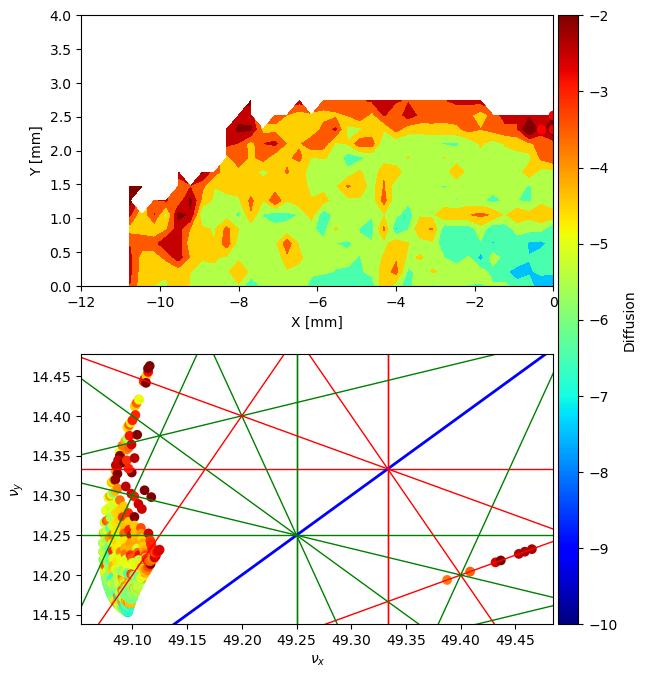

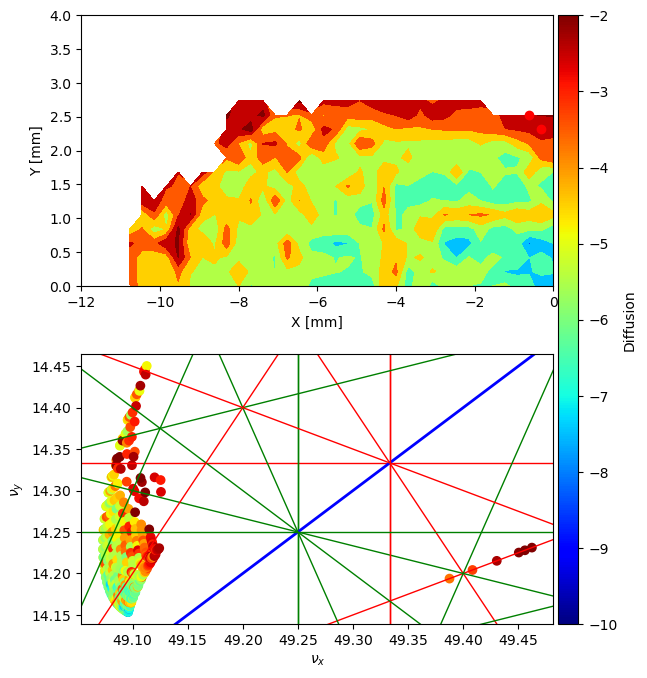

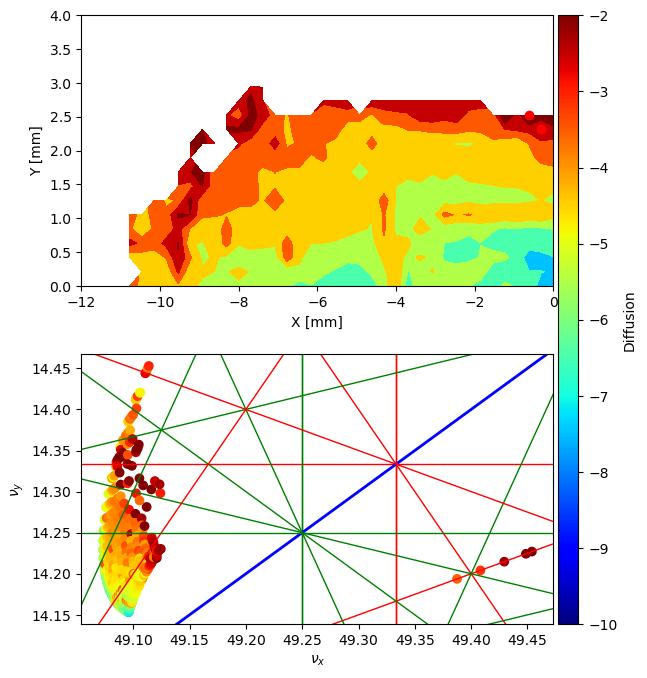

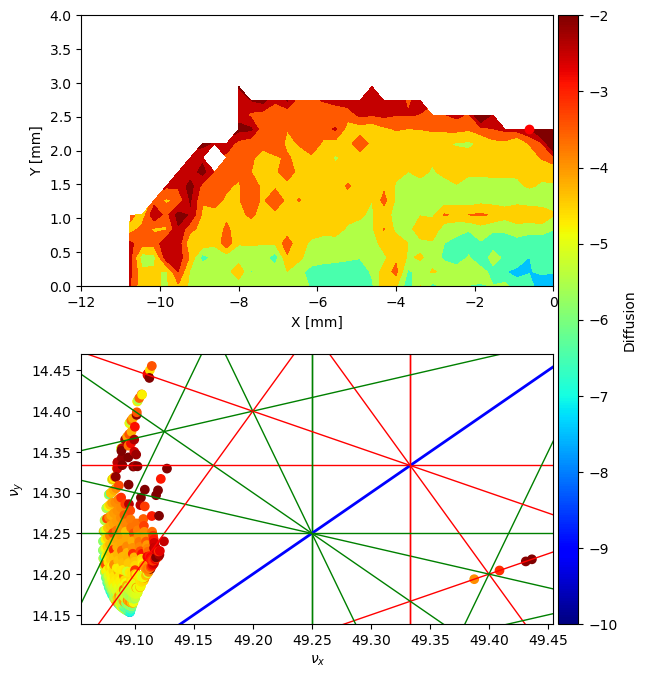

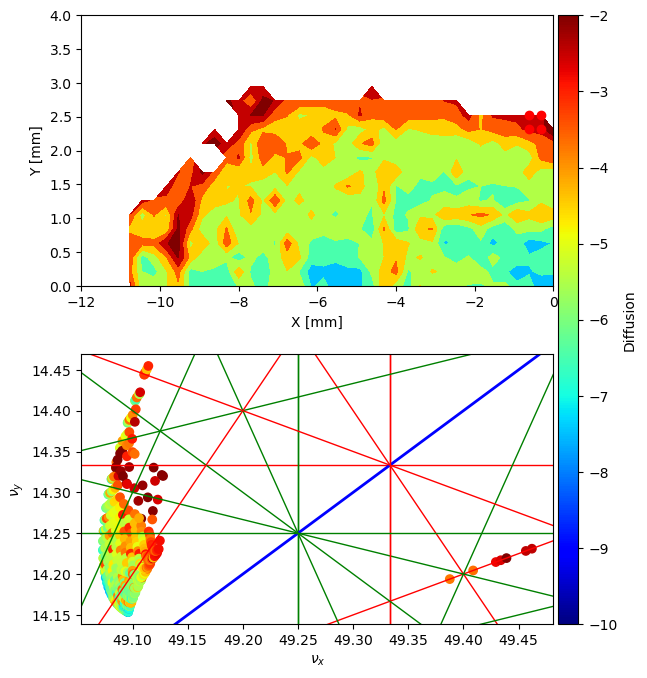

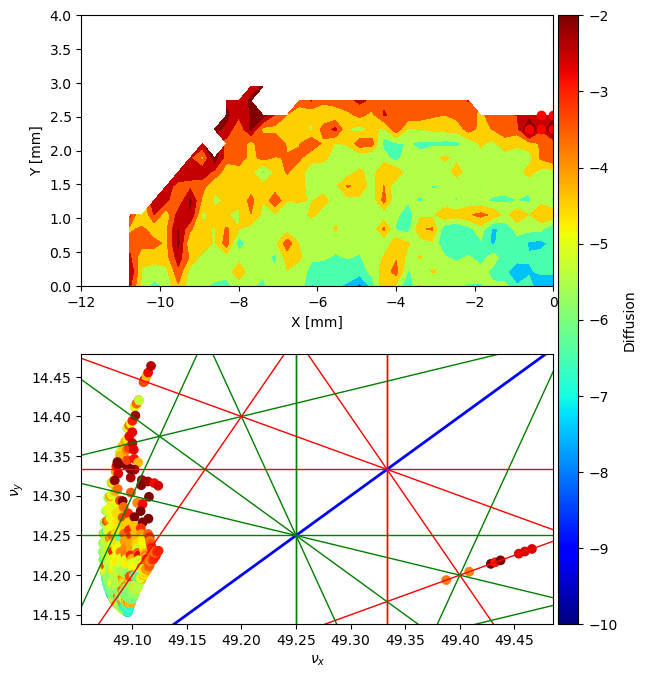

In [6]:
width = 68
widths = [68, 63, 58, 53, 48, 43, ]
pxf = [29.731, 52.124, 118.896, -64.921, -23.733, 17.008]
for width, shift in zip(widths, pxf):
    print(width)
    analysis_dynapt_map(width, shift,  corr='True')